In [1]:
import warnings
warnings.filterwarnings("ignore")

import pickle
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# https://sdv.dev/SDV/user_guides/single_table/ctgan.html
from ctgan import CTGANSynthesizer
from sklearn.base import BaseEstimator, TransformerMixin

MODELS_PATH = './models'
DATA_PATH = './data/'
dataset = 'adult'
seed = 1
np.random.seed(seed)

In [2]:
class ColumnsSelector(BaseEstimator, TransformerMixin):
  
    def __init__(self, type):
        print("ColumnsSelector init")
        self.type = type
  
    def fit(self, X, y=None):
        print("ColumnsSelector fit")
        return self

    def transform(self, X):
        print("ColumnsSelector transofrm")
        return X.select_dtypes(include=[self.type])

class CategoricalEncoder(BaseEstimator, TransformerMixin):
  
    def __init__(self, dropFirst=True):
        print("CategoricalEncoder init")
        self.categories = dict()
        self.dropFirst = dropFirst
    
    def fit(self, X, y=None):
        print("CategoricalEncoder fit")
        join_df = pd.concat([train_data, test_data])
        join_df = join_df.select_dtypes(include=['object'])
        for column in join_df.columns:
            self.categories[column] = join_df[column].value_counts().index.tolist()
        return self
    
    def transform(self, X):
        print("CategoricalEncoder transform")
        X_copy = X.copy()
        X_copy = X_copy.select_dtypes(include=['object'])
        for column in X_copy.columns:
            X_copy[column] = X_copy[column].astype({column: CategoricalDtype(self.categories[column])})
        return pd.get_dummies(X_copy, drop_first=self.dropFirst)

class CategoricalImputer(BaseEstimator, TransformerMixin):
  
    def __init__(self, columns = None, strategy='most_frequent'):
        print("CategoricalImputer init")
        self.columns = columns
        self.strategy = strategy
    
    def fit(self, X, y=None):
        print("CategoricalImputer fit")
        if self.columns is None:
            self.columns = X.columns

        if self.strategy is 'most_frequent':
            self.fill = {column: X[column].value_counts().index[0] for 
            column in self.columns}
        else:
            self.fill = {column: '0' for column in self.columns}

        return self
      
    def transform(self,X):
        print("CategoricalImputer transform")
        X_copy = X.copy()
        for column in self.columns:
            X_copy[column] = X_copy[column].fillna(self.fill[column])
        return X_copy

In [3]:
# load adult
# https://towardsdatascience.com/logistic-regression-classifier-on-census-income-data-e1dbef0b5738
def load_adult():
    columns = ["age",
               "workClass", 
               "fnlwgt", 
               "education", 
               "education-num",
               "marital-status", 
               "occupation", 
               "relationship",
               "race", 
               "sex", 
               "capital-gain", 
               "capital-loss",
               "hours-per-week", 
               "native-country", 
               "income"]
    
    train = pd.read_csv(os.path.join(DATA_PATH, 'adult/data'), names=columns, sep=' *, *', na_values='?', engine='python')
    test = pd.read_csv(os.path.join(DATA_PATH, 'adult/test'), names=columns, sep=' *, *', skiprows=1, na_values='?', engine='python')

#     test['income'].replace(regex=True, inplace=True, to_replace=r'\.', value=r'')
#     adult = pd.concat([test,train])
#     adult.reset_index(inplace=True, drop=True)
#     return adult,
    return train, test, columns

In [4]:
train_data, test_data, discrete_columns = load_adult()    

In [5]:
train_data.shape

(32561, 15)

# Train CTGAN with confidence level and black-box model

### CTGAN code structure:
1. **transformer.py** - implements _Mode-specific Normalization_ to continuous values, while categorical are encoded with OHE.

2. **synthesizer.py** - main code, implements fit (training GAN), predict (sample data), save and load. 

3. **models.py** - file contains Discriminator, Generator and Residual models.

4. **sampler.py** - TODO

5. **conditional.py** - TODO

In [6]:
# load rf model
with open(os.path.join(MODELS_PATH, 'adult_rf_0.852.pkl'), 'rb') as rf_fd:
    rf_model = pickle.load(rf_fd)
    
# load rf pipeline
with open(os.path.join(MODELS_PATH, 'adult_rf_0.852_pipeline.pkl'), 'rb') as pl_fd:
    rf_pipeline = pickle.load(pl_fd)

In [7]:
def gen_random_noise(shape):
    mu = 0
    sigma = 1
    z = sigma * np.random.randn(*shape) + mu
    return pd.DataFrame(z)

def plot_losses(hist, title):
    plt.figure(figsize=(10,5))
    plt.grid()
    plt.title(title, fontsize=25)
    plt.plot(hist["loss_g"], '-o', label="loss_g", linewidth=2.0)
    plt.plot(hist["loss_bb"], '-o', label="loss_bb", linewidth=2.0)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel("Number of epochs", fontsize=20)
    plt.ylabel('Loss', fontsize=20)
    plt.legend(loc='upper right', fontsize=10)
    plt.show()

Epoch 1, Loss G: 0.7842467457300714, loss_bb: 0.7842467457300714
Epoch 2, Loss G: 0.7880442885417461, loss_bb: 0.7880442885417461
Epoch 3, Loss G: 0.7667524751591097, loss_bb: 0.7667524751591097
Epoch 4, Loss G: 0.7738191801633927, loss_bb: 0.7738191801633927
Epoch 5, Loss G: 0.8008032379109442, loss_bb: 0.8008032379109442
Epoch 6, Loss G: 0.8103305405870298, loss_bb: 0.8103305405870298
Epoch 7, Loss G: 0.7336418189553368, loss_bb: 0.7336418189553368
Epoch 8, Loss G: 0.7671775711410739, loss_bb: 0.7671775711410739
Epoch 9, Loss G: 0.7325039759187428, loss_bb: 0.7325039759187428
Epoch 10, Loss G: 0.8002731305992046, loss_bb: 0.8002731305992046
Epoch 11, Loss G: 0.7200502378733097, loss_bb: 0.7200502378733097
Epoch 12, Loss G: 0.7857043080281365, loss_bb: 0.7857043080281365
Epoch 13, Loss G: 0.7516949051201802, loss_bb: 0.7516949051201802
Epoch 14, Loss G: 0.7379156609408095, loss_bb: 0.7379156609408095
Epoch 15, Loss G: 0.7076362793899117, loss_bb: 0.7076362793899117
Epoch 16, Loss G: 0

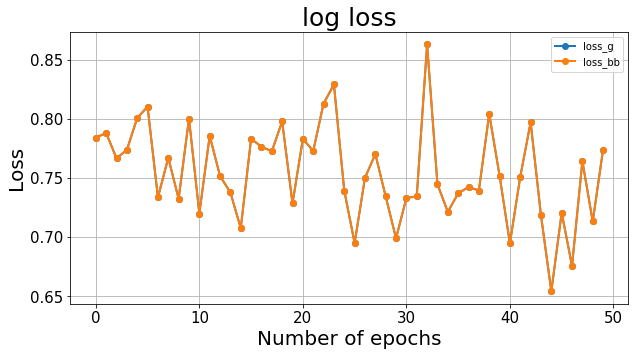


Epoch 1, Loss G: 0.3278406385344295, loss_bb: 0.3278406385344295
Epoch 2, Loss G: 0.3218485029634924, loss_bb: 0.3218485029634924
Epoch 3, Loss G: 0.3328981186605909, loss_bb: 0.3328981186605909
Epoch 4, Loss G: 0.33855232484156983, loss_bb: 0.33855232484156983
Epoch 5, Loss G: 0.3087248252395125, loss_bb: 0.3087248252395125
Epoch 6, Loss G: 0.377079613142325, loss_bb: 0.377079613142325
Epoch 7, Loss G: 0.30863669374205677, loss_bb: 0.30863669374205677
Epoch 8, Loss G: 0.3225769267878944, loss_bb: 0.3225769267878944
Epoch 9, Loss G: 0.31401050640231415, loss_bb: 0.31401050640231415
Epoch 10, Loss G: 0.37101940539524003, loss_bb: 0.37101940539524003
Epoch 11, Loss G: 0.32899110327002684, loss_bb: 0.32899110327002684
Epoch 12, Loss G: 0.31536285251306295, loss_bb: 0.31536285251306295
Epoch 13, Loss G: 0.32111499565463875, loss_bb: 0.32111499565463875
Epoch 14, Loss G: 0.31720392362434413, loss_bb: 0.31720392362434413
Epoch 15, Loss G: 0.3084093108359562, loss_bb: 0.3084093108359562
Epoc

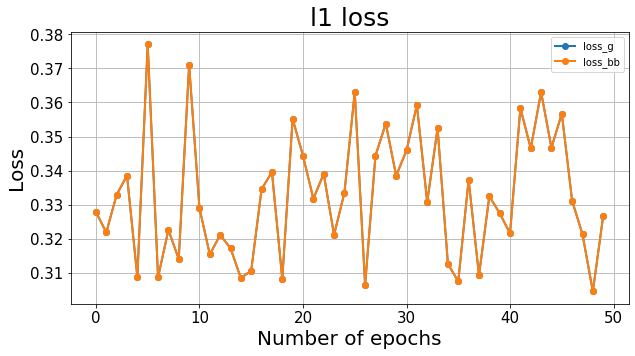

In [8]:
### losses check
z = gen_random_noise(shape=(10000, 81))
batch_size = 500
epochs = 50
confidence_level = 0.9 
gen_lr = 2e-5
# losses = ['log', 'l1', 'l2']
losses = ['log', 'l1']

for loss in losses:
    rf_ctgan = CTGANSynthesizer(batch_size=batch_size, 
                                blackbox_model=rf_model, 
                                preprocessing_pipeline=rf_pipeline, 
                                bb_loss=loss
                                )

    hist = rf_ctgan.fit(train_data=z, 
                        epochs=epochs,
                        confidence_level=confidence_level,
                        gen_lr=gen_lr,
                        )
    plot_losses(hist, title=loss + ' loss')
    print()

Epoch 1, Loss G: 1.4425956866699314, loss_bb: 1.4425956866699314
Epoch 2, Loss G: 1.489440980797897, loss_bb: 1.489440980797897
Epoch 3, Loss G: 1.4905644001573919, loss_bb: 1.4905644001573919
Epoch 4, Loss G: 1.458375689639171, loss_bb: 1.458375689639171
Epoch 5, Loss G: 1.3982356935143259, loss_bb: 1.3982356935143259
Epoch 6, Loss G: 1.476382637562626, loss_bb: 1.476382637562626
Epoch 7, Loss G: 1.4410837311523503, loss_bb: 1.4410837311523503
Epoch 8, Loss G: 1.4822091006554325, loss_bb: 1.4822091006554325
Epoch 9, Loss G: 1.4466465895849066, loss_bb: 1.4466465895849066
Epoch 10, Loss G: 1.5069160442256597, loss_bb: 1.5069160442256597
Epoch 11, Loss G: 1.4899375940065258, loss_bb: 1.4899375940065258
Epoch 12, Loss G: 1.5089579384280594, loss_bb: 1.5089579384280594
Epoch 13, Loss G: 1.4843650067297993, loss_bb: 1.4843650067297993
Epoch 14, Loss G: 1.459879682502103, loss_bb: 1.459879682502103
Epoch 15, Loss G: 1.452964265275487, loss_bb: 1.452964265275487
Epoch 16, Loss G: 1.475588504

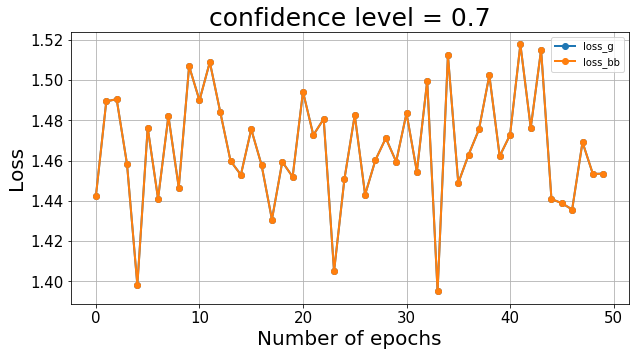

Epoch 1, Loss G: 1.5142773239060565, loss_bb: 1.5142773239060565
Epoch 2, Loss G: 1.4440967341668087, loss_bb: 1.4440967341668087
Epoch 3, Loss G: 1.4646045372774874, loss_bb: 1.4646045372774874
Epoch 4, Loss G: 1.5181122424222173, loss_bb: 1.5181122424222173
Epoch 5, Loss G: 1.4439409747650613, loss_bb: 1.4439409747650613
Epoch 6, Loss G: 1.4606984525998274, loss_bb: 1.4606984525998274
Epoch 7, Loss G: 1.5027485317896796, loss_bb: 1.5027485317896796
Epoch 8, Loss G: 1.535659578885008, loss_bb: 1.535659578885008
Epoch 9, Loss G: 1.4767746397108366, loss_bb: 1.4767746397108366
Epoch 10, Loss G: 1.518826191064123, loss_bb: 1.518826191064123
Epoch 11, Loss G: 1.4533656605481287, loss_bb: 1.4533656605481287
Epoch 12, Loss G: 1.523180025538153, loss_bb: 1.523180025538153
Epoch 13, Loss G: 1.5185795251495682, loss_bb: 1.5185795251495682
Epoch 14, Loss G: 1.5359592086644644, loss_bb: 1.5359592086644644
Epoch 15, Loss G: 1.539991432380159, loss_bb: 1.539991432380159
Epoch 16, Loss G: 1.4902130

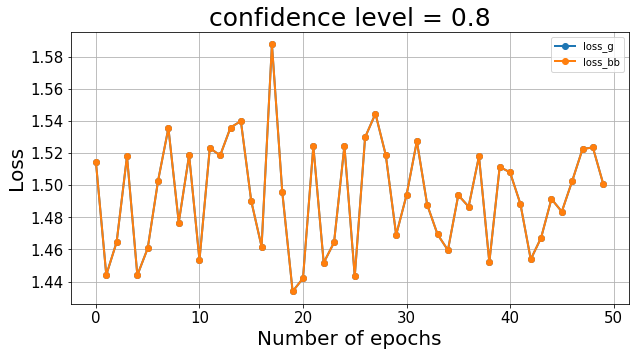

Epoch 1, Loss G: 1.1722136162945587, loss_bb: 1.1722136162945587
Epoch 2, Loss G: 1.164794576848847, loss_bb: 1.164794576848847
Epoch 3, Loss G: 1.197067408983238, loss_bb: 1.197067408983238
Epoch 4, Loss G: 1.1583120741234705, loss_bb: 1.1583120741234705
Epoch 5, Loss G: 1.1992230050881763, loss_bb: 1.1992230050881763
Epoch 6, Loss G: 1.1318808949647792, loss_bb: 1.1318808949647792
Epoch 7, Loss G: 1.1887021740398853, loss_bb: 1.1887021740398853
Epoch 8, Loss G: 1.0598162251851706, loss_bb: 1.0598162251851706
Epoch 9, Loss G: 1.168965374091713, loss_bb: 1.168965374091713
Epoch 10, Loss G: 1.116850513333315, loss_bb: 1.116850513333315
Epoch 11, Loss G: 1.136969847130472, loss_bb: 1.136969847130472
Epoch 12, Loss G: 1.151002682545931, loss_bb: 1.151002682545931
Epoch 13, Loss G: 1.1553360745052899, loss_bb: 1.1553360745052899
Epoch 14, Loss G: 1.1315828792808857, loss_bb: 1.1315828792808857
Epoch 15, Loss G: 1.2467304903860006, loss_bb: 1.2467304903860006
Epoch 16, Loss G: 1.17294582298

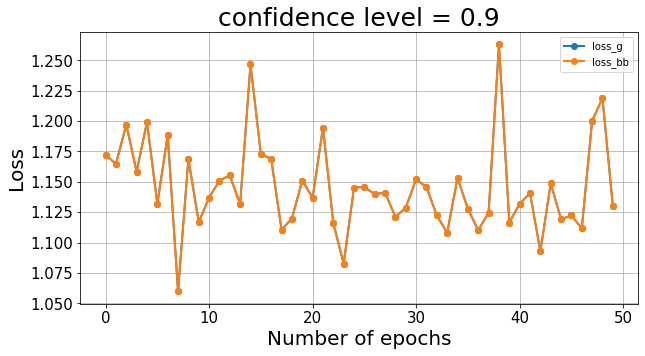

In [9]:
# confidence levels check
z = gen_random_noise(shape=(10000, 81))
batch_size = 500
epochs = 50
gen_lr = 2e-5
loss = 'log'
confidence_levels = [0.7, 0.8, 0.9]

for c in confidence_levels:
    rf_ctgan = CTGANSynthesizer(batch_size=batch_size, 
                                blackbox_model=rf_model, 
                                preprocessing_pipeline=rf_pipeline, 
                                bb_loss=loss
                                )

    hist = rf_ctgan.fit(train_data=z, 
                        epochs=epochs,
                        confidence_level=c,
                        gen_lr=gen_lr,
                        )
    plot_losses(hist, title=f"confidence level = {c}")
    